# Dereverberation

Description

In [1]:
# Reload the notebook if an external file is updated
%load_ext autoreload
%autoreload 2

import os
import sys

from pathlib import Path

path = (
    Path
    .cwd()
    .parent
    .parent
    .joinpath('warbler.py')
)

os.chdir(path)
sys.path.append(path)

In [2]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import soundfile as sf

from constant import DATASET, SETTINGS
from datatype.imaging import create_image
from datatype.plot import StandardSpectrogram
from datatype.settings import Settings
from datatype.signal import Signal
from datatype.spectrogram import create_spectrogram
from io import BytesIO
from nara_wpe.wpe import wpe
from nara_wpe.wpe import get_power
from nara_wpe.utils import stft, istft, get_stft_center_frequencies
from pathlib import Path
from scipy.io import wavfile
from tqdm import tqdm

WPE estimates a filter to predict the current reverberation tail frame from K time frames which lie 3 (delay) time frames in the past. 

This frame (reverberation tail) is then subtracted from the observed signal.

### Setup

In [3]:
channels = 2
sampling_rate = 44100
delay = 1
iterations = 500
taps = 10
alpha = 0.9999

### Audio data
Shape: (channels, frames)

In [4]:
# Default settings
path = SETTINGS.joinpath('spectrogram.json')
default = Settings.from_file(path)

path = DATASET.joinpath('DbWY_STE2017/segmentation/STE05_DbWY2017.json')
settings = Settings.from_file(path)

path = DATASET.joinpath('DbWY_STE2017/recordings/STE05_DbWY2017.wav')
reverberated = Signal(path)

if settings.bandpass_filter:
    reverberated.filter(
        settings.butter_lowcut,
        settings.butter_highcut
    )

if settings.normalize:
    reverberated.normalize()
    
if settings.reduce_noise:
    reverberated.reduce()

In [5]:
y = np.stack([reverberated.data], axis=0)
IPython.display.Audio(y[0], rate=reverberated.rate)

### STFT
A STFT is performed to obtain a Numpy array with shape (frequency bins, channels, frames).

In [6]:
stft_options = dict(
    size=512, 
    shift=128
)

In [7]:
Y = stft(y, **stft_options).transpose(2, 0, 1)

### Iterative WPE
The wpe function is fed with Y. Finally, an inverse STFT is performed to obtain a dereverberated result in time domain. 

In [8]:
Z = wpe(
    Y,
    taps=taps,
    delay=delay,
    iterations=iterations,
    statistics_mode='full'
).transpose(1, 2, 0)

z = istft(
    Z, 
    size=stft_options['size'], 
    shift=stft_options['shift']
)

buffer = BytesIO()

wavfile.write(
    buffer,
    reverberated.rate,
    z[0]
)

dereverberated = Signal(buffer)

IPython.display.Audio(
    dereverberated.data, 
    rate=dereverberated.rate
)

## Power spectrum 
Before and after applying WPE

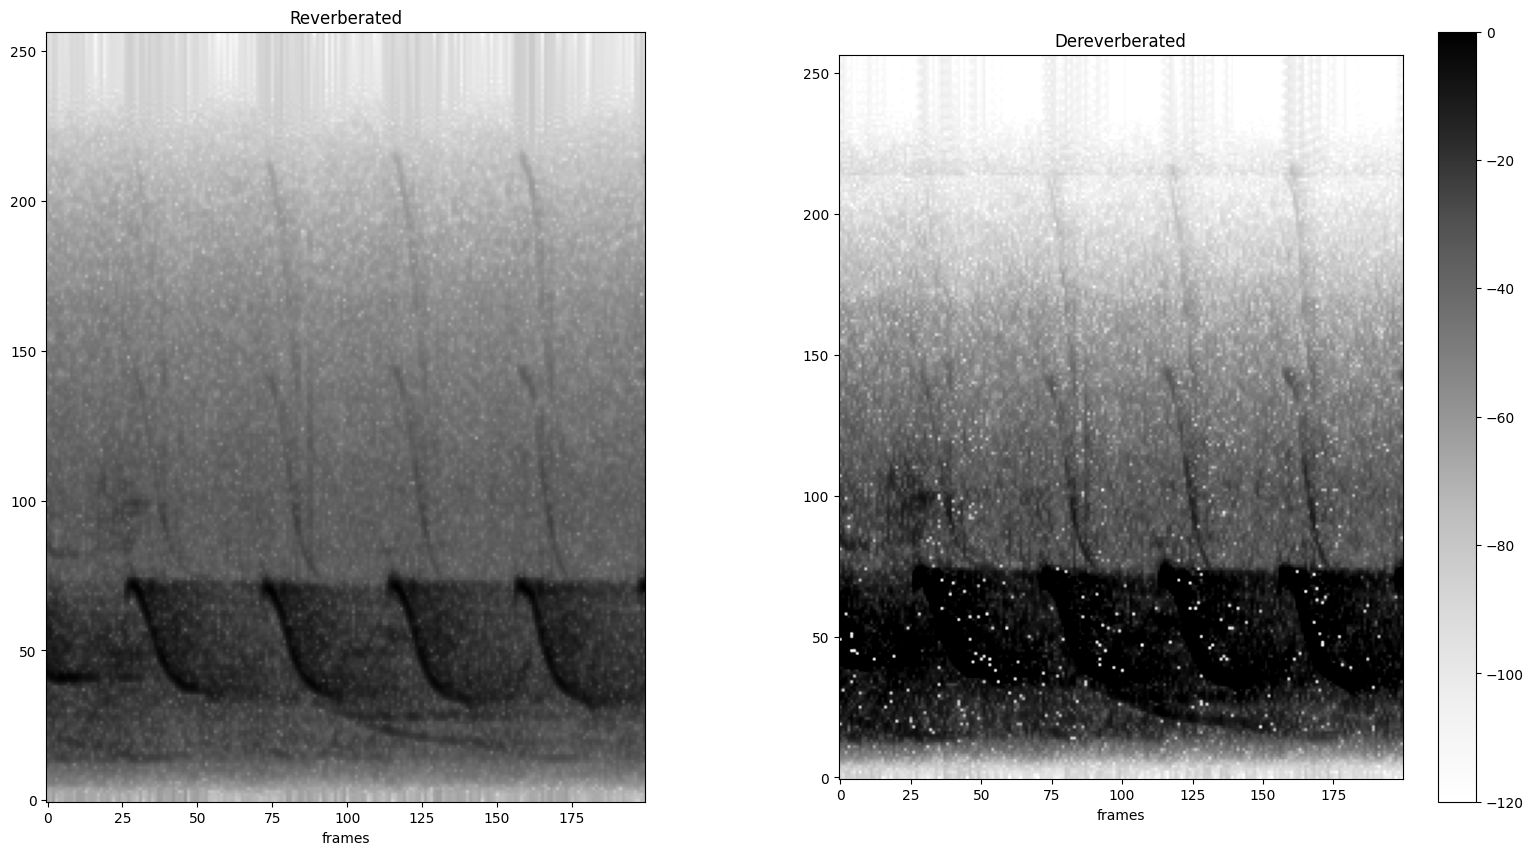

In [9]:
figsize = (20, 10)

fig, [ax1, ax2] = plt.subplots(
    1, 
    2, 
    figsize=figsize
)

im1 = ax1.imshow(
    20 * np.log10(
        np.abs(Y[ :, 0, 200:400])
    ), 
    origin='lower',
    cmap='Greys'
)

ax1.set_xlabel('frames')
ax1.set_title('Reverberated')

im2 = ax2.imshow(
    20 * np.log10(
        np.abs(Z[0, 200:400, :])
    ).transpose(), 
    origin='lower',
    cmap='Greys',
    vmin=-120, 
    vmax=0
)

ax2.set_xlabel('frames')
ax2.set_title('Dereverberated')

cb = fig.colorbar(im2)

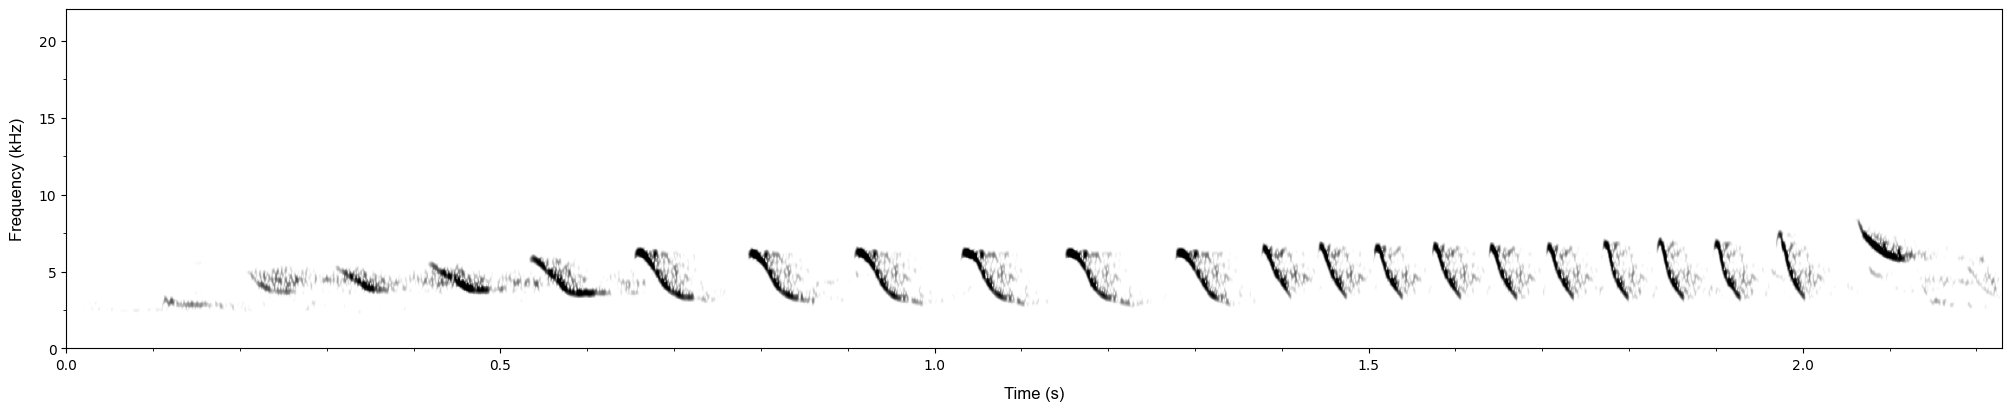

In [10]:
spectrogram = create_spectrogram(reverberated, default)

plot = StandardSpectrogram()
plot.signal = reverberated
plot.spectrogram = spectrogram
plot.create()

plt.show()

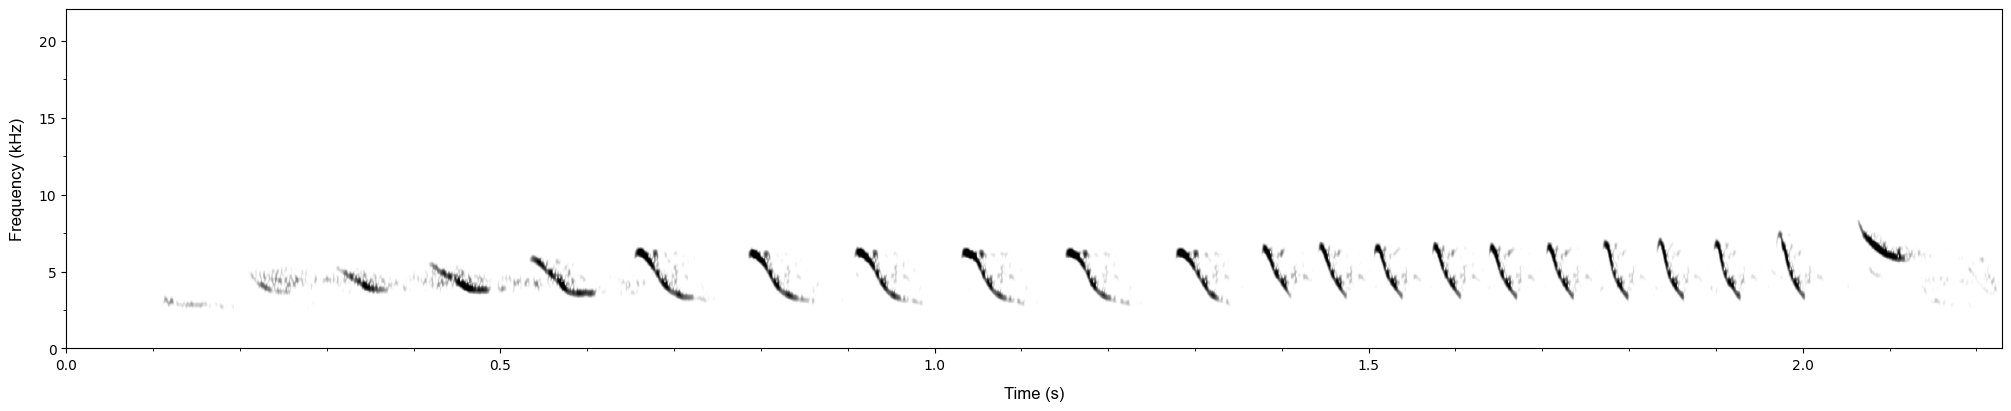

In [11]:
spectrogram = create_spectrogram(dereverberated, default)

plot = StandardSpectrogram()
plot.signal = reverberated
plot.spectrogram = spectrogram
plot.create()

plt.show()